In [1]:
from pathlib import Path

import cv2
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
data_folder = Path("/workdir/strawberry_hack/images/")

In [3]:
img_paths = list(data_folder.iterdir())
len(img_paths)

2041

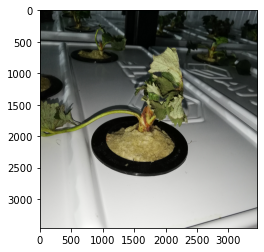

In [4]:
idx = np.random.randint(0, len(img_paths))
img = cv2.imread(str(img_paths[idx]))[..., ::-1]
imshow(img);

In [5]:
LOWER_GREEN = (20, 0, 0)
UPPER_GREEN = (60, 255, 255)

In [6]:
def segment_leaves(img):
    hsv_plant = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_plant)
    # h_ = cv2.equalizeHist(h)
    # s_ = cv2.equalizeHist(s)
    v_ = cv2.equalizeHist(v)
    hsv_plant = cv2.merge((h, s, v_))
    mask = cv2.inRange(hsv_plant, LOWER_GREEN, UPPER_GREEN)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((35, 35), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((19, 19), np.uint8))
    result = cv2.bitwise_and(img, img, mask=mask)
    
    return result, mask

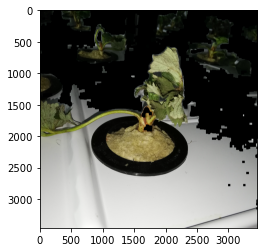

In [7]:
result, mask = segment_leaves(img)
imshow(result);

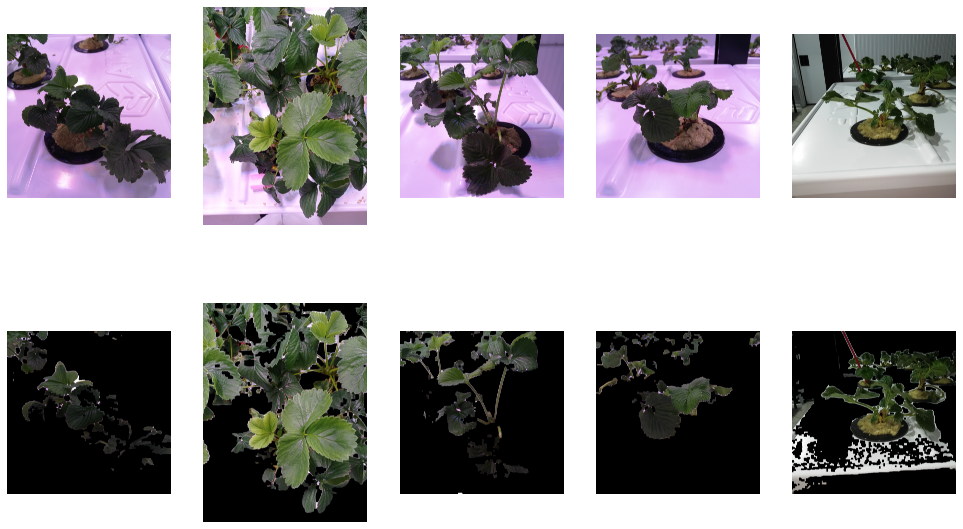

In [8]:
indices = np.random.choice(np.arange(0, len(img_paths)), size=5)
images = [cv2.imread(str(img_paths[idx]))[..., ::-1] for idx in indices]
results = [segment_leaves(img)[0] for img in images]

fig, axs = plt.subplots(nrows=2, ncols=len(images), figsize=(17, 10))
for i, (img, res) in enumerate(zip(images, results)):
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[1, i].imshow(res)
    axs[1, i].axis('off')

In [31]:
leaf_images_dir = Path("/workdir/strawberry_hack/images")
leaf_masks_dir = Path("/workdir/strawberry_hack/leaf_masks")
leaf_masks_dir.mkdir(parents=True, exist_ok=True)

In [38]:
labels = {"image_path": [], "mask_path": []}
for img_path in tqdm(list(leaf_images_dir.iterdir())):
    img = cv2.imread(str(img_path))[..., ::-1]
    result, mask = segment_leaves(img)
    mask_path = leaf_masks_dir / (img_path.stem + ".png")
    cv2.imwrite(str(mask_path), (mask > 0).astype(np.uint8))
    
    labels["image_path"].append(str(img_path.relative_to("/workdir/strawberry_hack")))
    labels["mask_path"].append(str(mask_path.relative_to("/workdir/strawberry_hack")))

100%|██████████| 2041/2041 [17:25<00:00,  1.95it/s]


In [39]:
labels = pd.DataFrame(labels)
labels.shape

(2041, 2)

In [40]:
labels.head()

,image_path,mask_path
0,images/IMG_20210227_122352.jpg,leaf_masks/IMG_20210227_122352.png
1,images/IMG_20210913_104837.jpg,leaf_masks/IMG_20210913_104837.png
2,images/IMG_20210729_104851.jpg,leaf_masks/IMG_20210729_104851.png
3,images/IMG_20210201_135204.jpg,leaf_masks/IMG_20210201_135204.png
4,images/E7D16BC9-065E-4F71-8548-73B98D7CE426_1_...,leaf_masks/E7D16BC9-065E-4F71-8548-73B98D7CE42...


In [41]:
labels.to_csv("/workdir/strawberry_hack/leaves_all.csv", index=False)

In [42]:
train, valid = train_test_split(labels, test_size=0.2, shuffle=True, random_state=123)
train.shape, valid.shape

((1632, 2), (409, 2))

In [43]:
train.to_csv("/workdir/strawberry_hack/leaves_train.csv", index=False)
valid.to_csv("/workdir/strawberry_hack/leaves_valid.csv", index=False)

## Filter masks

In [ ]:
leaf_images_dir = Path("/workdir/strawberry_hack/images_720p/")
leaf_masks_dir = Path("/workdir/strawberry_hack/leaf_overlay_720p/")
leaf_masks_dir.mkdir(parents=True, exist_ok=True)

for img_path in tqdm(list(leaf_images_dir.iterdir())):
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    img = img[..., ::-1]
    result, mask = segment_leaves(img)
    
    overlay = img.copy()
    overlay[mask > 0] = [0, 0, 255]
    res = cv2.addWeighted(img, 0.5, overlay, 0.5, 1.)
    
    mask_path = leaf_masks_dir / img_path.name
    cv2.imwrite(str(mask_path), res[..., ::-1])

100%|█████████▉| 2035/2042 [02:22<00:00, 13.16it/s]